# Beleg 2: Diffusion

## Hinweise zum Beleg:
- Die erfolgreiches Bestehen des Belegs ist Voraussetzung zum Bestehen des Kurses. 
- Sofern nicht anders angegeben können die Operationen mit einer Library Ihrer Wahl durchgeführt werden (Hinweise dienen nur als Hilfestellung, Sie dürfen andere Lösungswege einschlagen)
- Geben Sie den Beleg als ipynb (in einem zip) ab - verzichten Sie auf eine Abgabe der Daten aber halten Sie bitte die in Aufgabe 1 von Beleg 1 geforderte Struktur ein.
- Tragen Sie bitte Ihren Namen und Matrikelnummer oben ein
- Nutzen Sie bitte die gleiche Daten/Code Verzeichnisstruktur wie im Beleg 1

## Inhalt
In diesem Beleg wollen wir das Training eines DDPM Modells nachvollziehen. 

Grundlage des Belegs ist das pokemon dataset, welches Sprites der Animation einzelner Pokemon aus den Pokemon Spielen enhält. Ziel ist es auf diesen (bzw. einem Teil von diesen) Daten zu trainieren um künstliche Bilder von Pokemon erzeugen zu können. Lernzeil soll hierbei sein ein Verständnis zu erhalten für:


- Grundlagen zur Implementierung von CNNs mit pytorch
- Grundlagen zur Umsetztung eines DDPM Training
- Ablauf (z.B. Laufzeit) sowie für die zu erwartenden Resultate eines DDPM Training
- Grundlagen zum Erzeugen von Bildern mit einem trainierten Modell 

In [1]:
# Grundlegenden Importe: erweitern Sie diese falls nötig

import torch
import torchvision
import torch.nn as nn
import os
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch import optim
from torchvision.transforms import transforms

from tqdm import tqdm

## Aufgabe 1 - UNet

Unten finden Sie code für die grundlegenden Bausteine eines UNets. 
 - ConvBlock definiert eine Folge von zwei Conv2d Layer welche die Anzahl der Kanäle verändern aber die Auflösung intakt lassen
 - Down definiert einen downsampling Block bei dem die Auflösung halbiert wird, ein ConvBlock angewendet wird sowie der Zeitpunkt t mit einbezogen wird
 - Up definiert einen upsampling Block bei dem die Auflösung verdoppelt wird, ein ConvBlock angewendet wird sowie der Zeitpunkt t und ein x vom downsampling path mit einbezogen wird


### Aufgabe 1.1
Füllen Sie die Definition des UNets unten weiter auf:

Aktuell besteht das UNet aus 

    - einer Anfangslayer (inc) welche die Anzahl der Kanäle auf 64 erhöht (mittels eines ConvBlocks)
    - einer Outputlayer (outc) welche die Anzahl der Kanäle auf 3 vermindert (mittels einer Conv2d Layer mit kernel_size=1)
    
    - einem positional encoding der Zeit von einer Zahl in einen Vektor welcher sich stabiler verarbeiten lässt
    
Ergänzen Sie dies um 

    - einen Downsampling path der aus 1 (oder mehr falls Sie die erhöhte Laufzeit umsetzen können) Down-Block besteht (der letzte Down-Block sollte Hierbei die Anzahl der Kanäle konstant lassen)
    
    - einem Zentrum welches z.B. aus 3 ConvBlock Blöcken bestehen die die Anzahl der Kanäle verdoppeln und dann wieder halbieren (um mit der selben Anzahl der Kanäle zu enden)
    
    - einem Upsampling path der aus mindestens einem (oder wieder analog mehr) Up-Block besteht
    
Achten Sie hierbei auf die skip-Verbindungen zwischen dem Down und dem Up-Path sowie dass dort jeweils das bereits aufbereitete t beigegeben wird.


### Aufgabe 1.2

Testen Sie Ihre Implementierung in dem Sie einen Tensor der shape (4,3,48,48) sowie ein t der shape (4,) erzeugen und von dem Netzwerk verarbeiten lassen. 

Laden Sie ein beliebiges quadratisches Bild aus dem Pokemon Datensatz und lassen Sie es von dem Netzwerk verarbeiten. Visualisieren Sie das Bild und den Output des Netzwerkes mittels plt.imshow

### Aufgabe 1.3

Geben Sie die Anzahl der Parameter des Netzwerkes aus

In [2]:
#Image Network

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
                                         nn.GroupNorm(1, mid_channels),
                                         nn.GELU(),
                                         nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                         nn.GroupNorm(1, out_channels))
    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2),ConvBlock(in_channels, out_channels))
        self.t_emb_layer = nn.Linear(emb_dim,out_channels)

    def forward(self, x, t):
        x = self.pool_conv(x)
        emb = self.t_emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(ConvBlock(in_channels, out_channels, in_channels // 2))
        self.t_emb_layer = nn.Linear(emb_dim,out_channels)

    def forward(self, x, x_skip, t):
        x = self.up(x)
        x = torch.cat([x_skip, x], dim=1)
        x = self.conv(x)
        emb = self.t_emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

    
class SmallUNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, image_size=16, time_dim=64, device="cpu"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.c_in = c_in
                
        self.inc = ConvBlock(c_in, 64)
        
        #down path
        self.down = Down(64, 64, time_dim)
 
        # center
        self.center = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 64))

        # up path
        self.up = Up(128, 64, time_dim)
        
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, time_dim):
        inv_freq = 1.0 / (10000**(torch.arange(0, time_dim, 2, device=self.device).float() / self.c_in))
        pos_enc_a = torch.sin(t.repeat(1, time_dim // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, time_dim // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        # Down path
        x_skip0 = self.inc(x)
        
        x_skip = self.down(x_skip0, t)
        
        # Center
        x_center = self.center(x_skip0)
        
        # Up path
        x_up = self.up(x_skip, x_center, t) 

        # Out
        x_out = self.outc(x_up)
        
        return x_out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


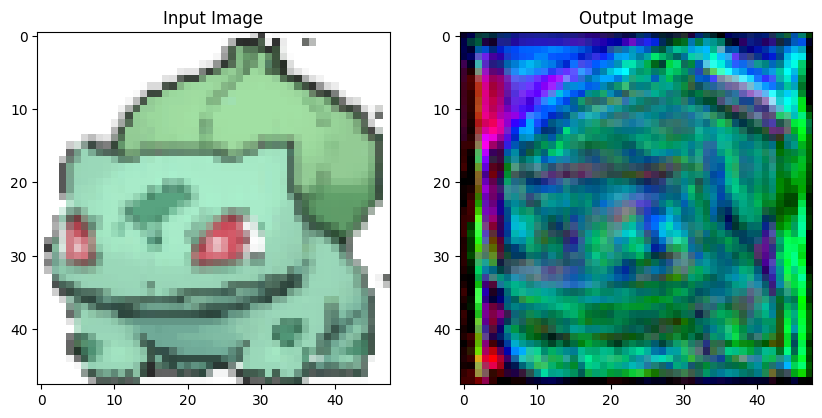

In [94]:
# Aufgabe 1.2
from PIL import Image

input_tensor = torch.rand((4, 3, 48, 48))
t = torch.linspace(-1, 1, 4)

unet = SmallUNet()
device = "cpu"

output = unet(input_tensor, t)

# Pokemon Testing
image_path = "pokemon_test/1/1-1.png"
image = Image.open(image_path)

# rgba to rgb
rgb_image = image.convert("RGB")

transform_image = transforms.Compose([
    transforms.Resize((48, 48)), 
    transforms.ToTensor(),        
])
input_image = transform_image(rgb_image).unsqueeze(0).to(device)

output = unet(input_image, torch.tensor([0.0]).to(device))

# Zeige das Bild und den Ausgabetensor an
input_image = input_image.squeeze().cpu().numpy().transpose(1, 2, 0)
output_image = output.squeeze().cpu().detach().numpy().transpose(1, 2, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image)

plt.subplot(1, 2, 2)
plt.title("Output Image")
plt.imshow(output_image)

plt.show()

In [95]:
# Aufgabe 1.3

def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

smallunet_params = count_model_parameters(unet)
print("Anzahl der Parameter des Netzwerkes: ", smallunet_params)

Anzahl der Parameter des Netzwerkes:  860163


## Aufgabe 2 - Diffusion

Unten finden Sie das Grundgerüst einer Diffusion Klasse welche alle notwendigen Elemente des Diffusionsprozesses implementieren soll

### Aufgabe 2.1
Implementieren Sie die forward_diffusion welche das erzeugt x_t und verwendete Rauschen epsilon zurückgibt

### Aufgabe 2.2

Implementieren Sie die reverse_diffusion welche die erzeugen Bilder x_0 zurückgibt

Versetzen Sie dafür das übergebene Modell dafür in den Evaluationsmodus (mittels model.eval(), wobei Sie am Ende der Methode ein weiteres Training wieder mit model.train() erlauben müssen) und nutzen Sie einen "with torch.no_grad():" Block um die Berechnung zu beschleunigen

### Aufgabe 2.3

Laden Sie ein beliebiges Bild aus dem pokemon Datensatz und führen Sie die forward_diffusion aus für 

    - T = 1000
    - beta_0 = 1E-4
    - beta_T = 0.02
    
und plotten Sie die resultierenden x_t für t = 0,200,400,600,800,1000 (achten Sie darauf, die data_shape für die Diffusion entsprechend zu wählen).


In [96]:
class Diffusion:
    def __init__(self, T=1000, beta_0=1e-4, beta_T=0.02, data_shape=(48,48), device="cpu"):
        self.data_shape = data_shape # shape of the images
        self.device = device # device to do the computation on (needed if you have / want to use a GPU)

        self.T = T # Anzahl der t's
        self.beta_0 = beta_0
        self.beta_T = beta_T
        # beta_t Liste mit beta_t = self.beta[t]
        self.beta = torch.linspace(self.beta_0, self.beta_T, self.T).to(device)

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def sample_timesteps(self, number_of_ts):
        # erlaubt es passende Zeiten t für das Training das DDPMs zu samplen
        return torch.randint(low=1, high=self.T, size=(number_of_ts,))
    
    def forward_diffusion(self, x_0, t):
        epsi = torch.randn_like(x_0)
    
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])
        sqrt_one_minus_alpha_bar= torch.sqrt(1. - self.alpha_bar[t])
                
        sqrt_alpha_bar_reshaped = sqrt_alpha_bar.view(-1, 1, 1, 1)  # matches x_0.shape
        sqrt_one_minus_alpha_bar_reshaped = sqrt_one_minus_alpha_bar.view(-1, 1, 1, 1)
                
        x_t = sqrt_alpha_bar_reshaped * x_0 + sqrt_one_minus_alpha_bar_reshaped * epsi
        
        return x_t, epsi

    def reverse_diffusion(self, model, number_of_images):
        model.eval()

        with torch.no_grad():
            x_0 = torch.randn((number_of_images, 3, self.data_shape[0], self.data_shape[1])).to(self.device)
            
            for i in tqdm(reversed(range(1, self.T)), position = 0):
                t = (torch.ones(number_of_images) * i).long().to(self.device)
                predicted_noice = model(x_0, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noice = torch.randn_like(x_0)
                else:
                    noice = torch.zeros_like(x_0)
                    
                x_0 = 1 / alpha.sqrt() * (x_0 - ((1 - alpha) / (1 - alpha_bar).sqrt()) * predicted_noice) + beta.sqrt() * noice

        # training mode
        model.train()
         
        return x_0

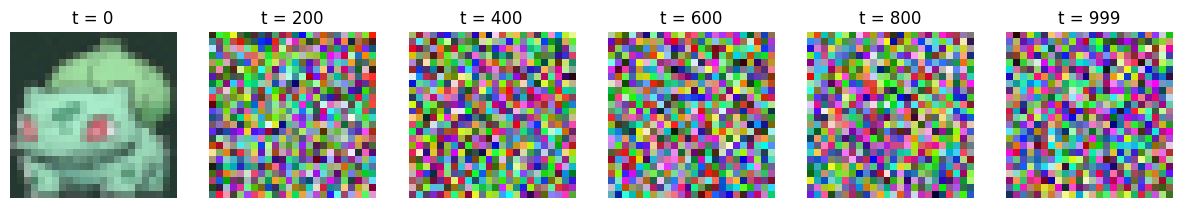

In [97]:
# Aufgabe 2.3

image_path = "pokemon_test/1/1-0.png"
image = Image.open(image_path)

# rgba to rgb
rgb_image = image.convert("RGB")

# transform to torch image
transform_image = transforms.Compose([ 
    transforms.Resize((24, 24)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# reverse transformation to PIL image for plotting
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.ToPILImage()
])

x_0 = transform_image(rgb_image)

T=1000
beta_0=1e-4
beta_T=0.02

diffusion = Diffusion(data_shape=(24,24),T=T,beta_0=beta_0, beta_T=beta_T)

timesteps = [0, 200, 400, 600, 800, 999]
images = []

num_timesteps = len(timesteps)
        
x_t_list = []

for t in timesteps:
    x_t, _ = diffusion.forward_diffusion(x_0, t)
    x_t_list.append(x_t)
    x_0 = x_t
    
x_t_stack = torch.stack(x_t_list, dim=0)
epsi_stack = torch.stack(epsi_list, dim=0)
        
for img in x_t_stack:
    images.append(reverse_transform(img.squeeze(0)))

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"t = {timesteps[i]}")
    ax.axis("off")
plt.show()

## Aufgabe 3 - Daten

Laden Sie analog zu Beleg1 einen Teil oder den gesamten pokemon Datensatz, wobei Sie die transformation unten inklusive eines resize verwenden sollen. 
Wählen Sie eine passende image_size (gute Ergebnisse lassen sich hier im Bereich image_size = 24 - 48 erzielen, achten Sie darauf, dass die Auflösung gut halbiert etc. werden kann entsprechend Ihrer UNet Architektur; bei Werten für die image_size über 40 sollten Sie die Lernrate unten verminder - bei sehr kleinen Bilder (z.B. 24) kann die Lernrate testweise auf 1E-3 erhöht werden)

In [98]:
# Data
data_dir = "data/pokemon_small"
pokemon = torchvision.datasets.ImageFolder(data_dir)

image_size = 24

batch_size = 128
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_size,image_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer

data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True)

## Aufgabe 4 - Training

Implementieren Sie das Training des DDPMs druch folgende Schritte

  - iterieren Sie in jeder Epoche durch die Bilder von dataloader (wobei sie das Element der Form (x_0,y) erhalten bei denen Sie das y verwerfen können )
  - für einen Batch Bilder
      - nullen Sie die Gradienten mittels optimizer.zero_grad()
      - samplen Sie Zeiten t
      - erzeugen Sie die x_t mittels der forward_diffusion
      - erzeugen Sie das vorhergesagte Rauschen mittels model
      - bestimmen Sie den loss
      - rufen Sie die Backpropagation auf mittels der .backward routine des bestimmten losses
      - updaten Sie die Parameter mittels optimizer.step()
  - samplen Sie alle X Epochen (z.B. X = 10 oder 100) eine gewisse Anzahl (z.B. 10) an Bildern und plotten Sie diese um den Trainingsverlauf zu zu beobatchten

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Epoch [10/1000], Loss: 0.81640


999it [01:25, 11.69it/s]


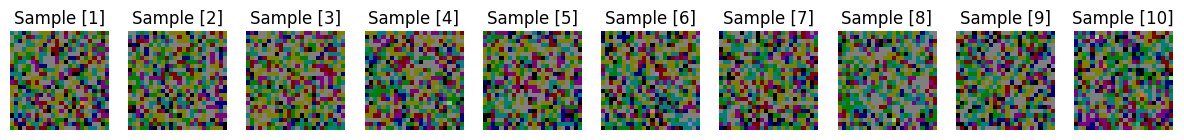

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [20/1000], Loss: 0.41939


999it [01:32, 10.76it/s]


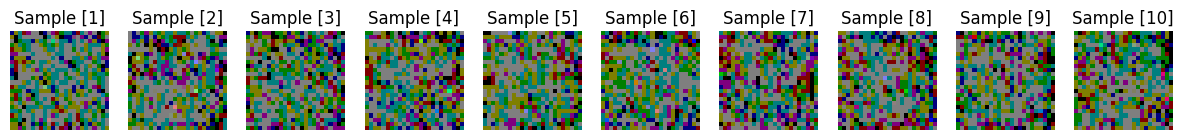

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [30/1000], Loss: 0.23940


999it [01:32, 10.83it/s]


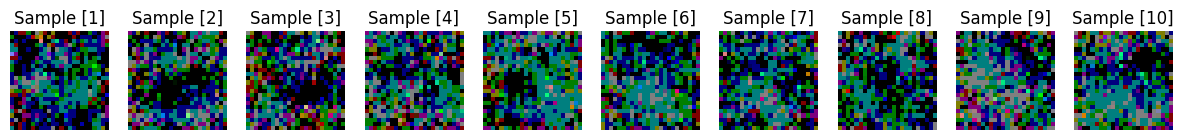

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [40/1000], Loss: 0.19974


999it [01:33, 10.65it/s]


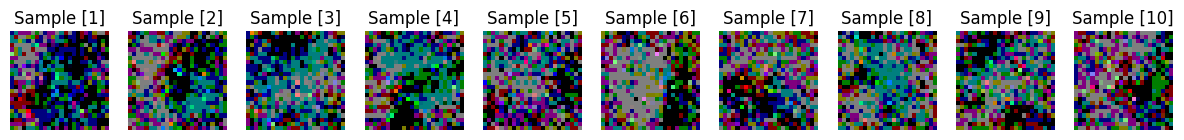

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [50/1000], Loss: 0.17999


999it [01:32, 10.76it/s]


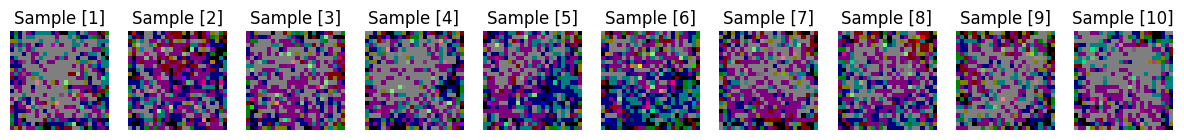

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [60/1000], Loss: 0.16004


999it [01:32, 10.83it/s]


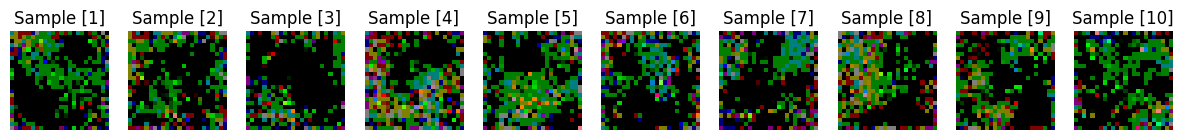

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch [70/1000], Loss: 0.16461


999it [01:32, 10.83it/s]


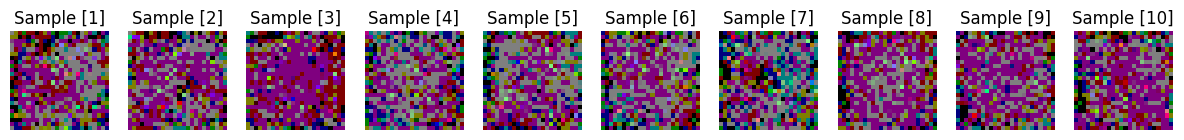

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [80/1000], Loss: 0.13179


999it [01:32, 10.80it/s]


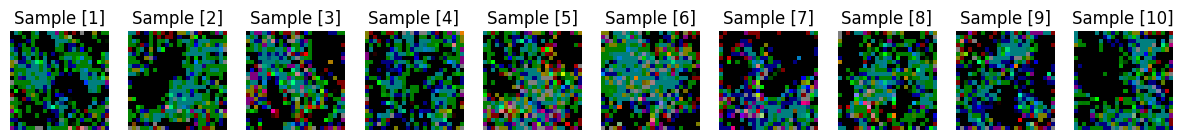

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Epoch [90/1000], Loss: 0.14118


999it [01:41,  9.82it/s]


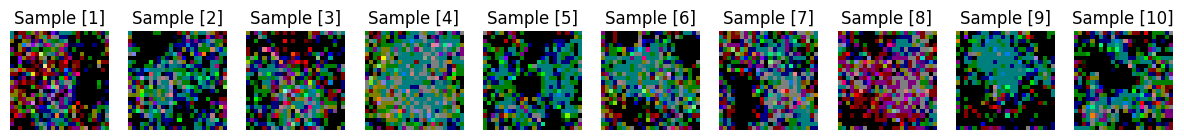

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch [100/1000], Loss: 0.13303


999it [01:36, 10.36it/s]


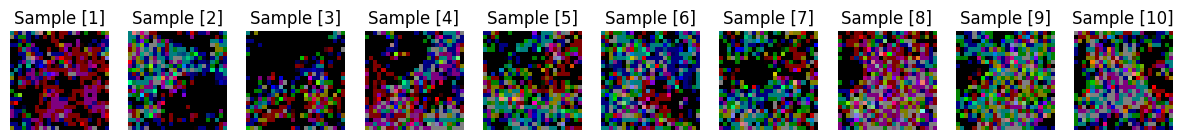

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [110/1000], Loss: 0.11872


999it [01:35, 10.42it/s]


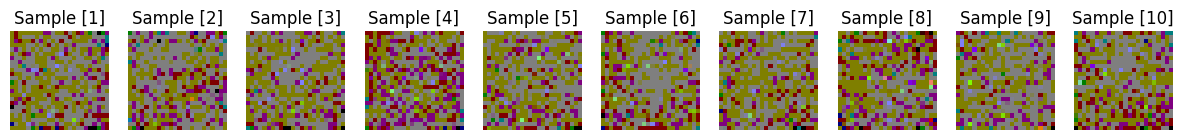

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch [120/1000], Loss: 0.10065


999it [01:35, 10.43it/s]


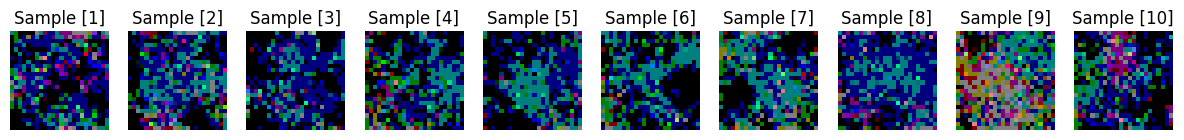

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [130/1000], Loss: 0.10242


999it [01:35, 10.46it/s]


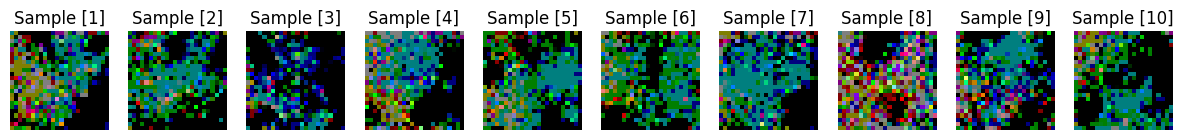

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [140/1000], Loss: 0.10862


999it [01:35, 10.45it/s]


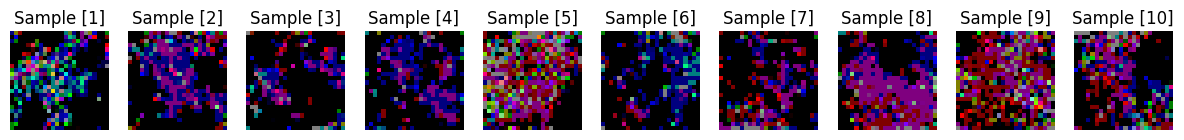

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch [150/1000], Loss: 0.07805


999it [01:36, 10.36it/s]


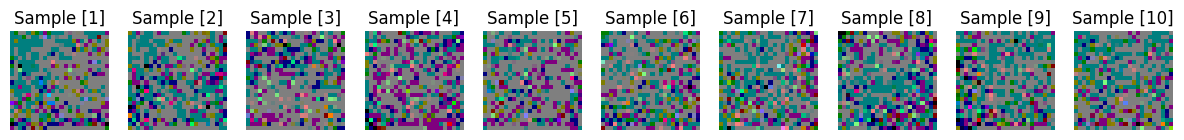

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch [160/1000], Loss: 0.07494


999it [01:35, 10.48it/s]


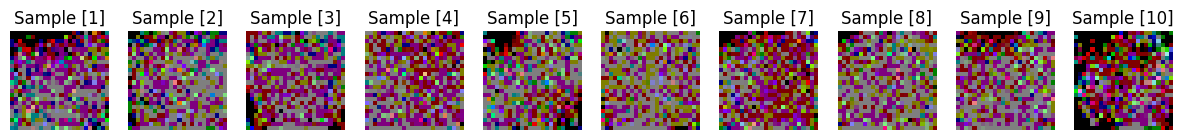

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch [170/1000], Loss: 0.08348


999it [01:34, 10.55it/s]


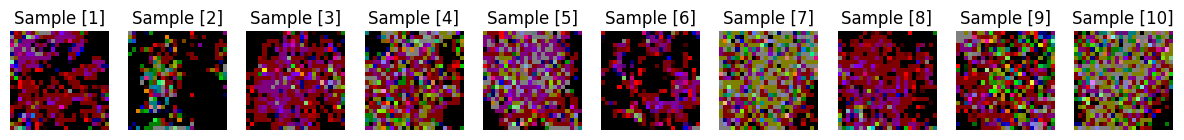

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [180/1000], Loss: 0.06990


999it [01:35, 10.51it/s]


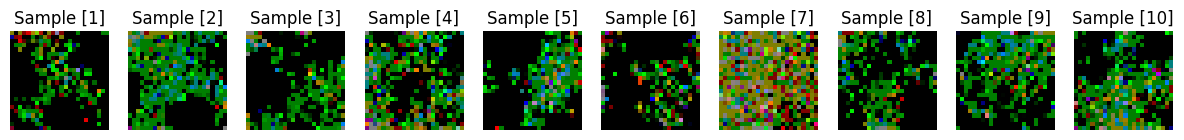

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [190/1000], Loss: 0.07718


999it [01:34, 10.52it/s]


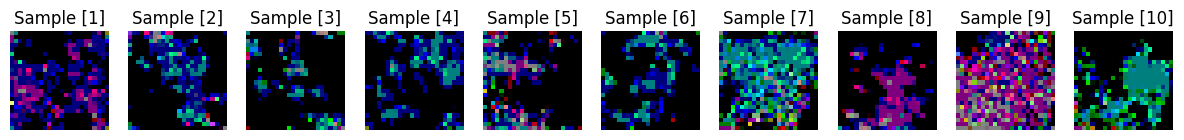

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch [200/1000], Loss: 0.07854


999it [01:34, 10.52it/s]


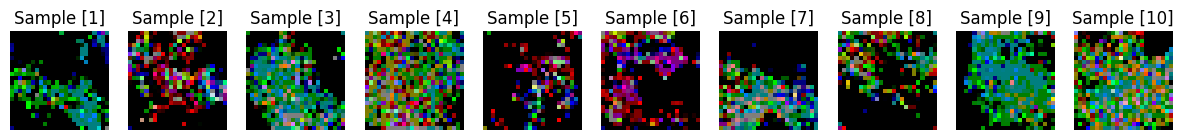

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [210/1000], Loss: 0.07216


999it [01:30, 11.01it/s]


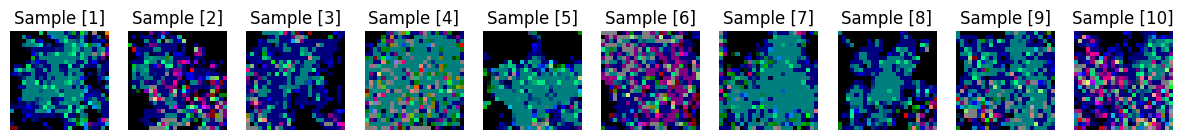

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch [220/1000], Loss: 0.09114


999it [01:30, 11.03it/s]


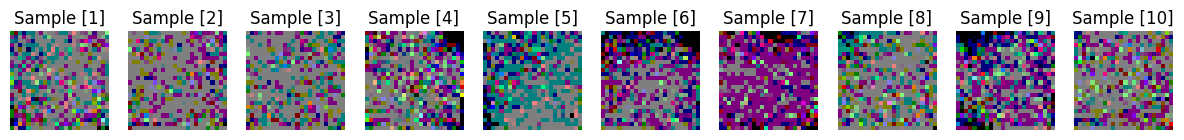

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [230/1000], Loss: 0.07507


999it [01:31, 10.98it/s]


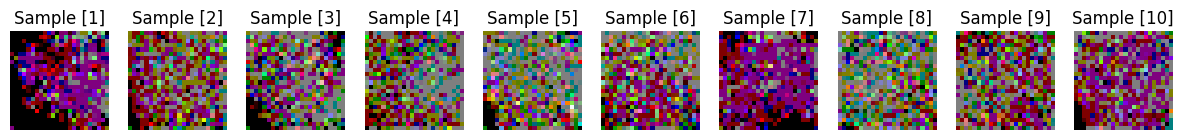

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


Epoch [240/1000], Loss: 0.08317


999it [01:29, 11.14it/s]


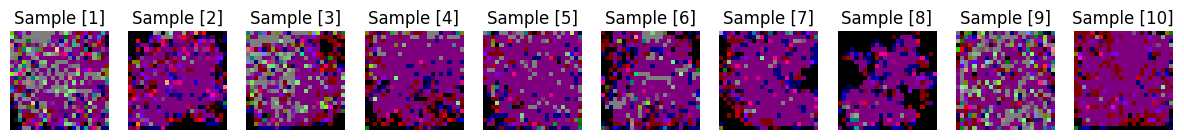

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch [250/1000], Loss: 0.05132


999it [01:30, 11.10it/s]


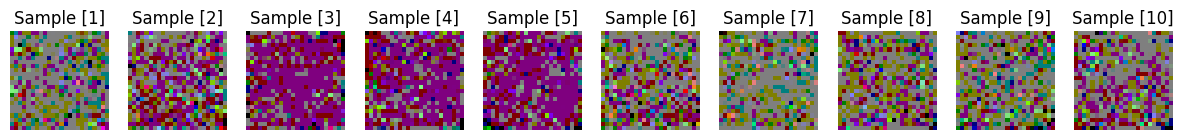

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch [260/1000], Loss: 0.05271


999it [01:30, 11.01it/s]


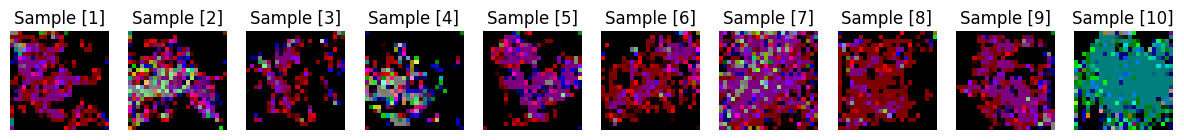

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [270/1000], Loss: 0.06612


999it [01:29, 11.13it/s]


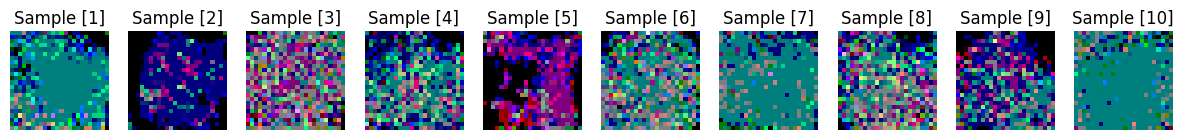

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [280/1000], Loss: 0.05611


999it [01:30, 11.02it/s]


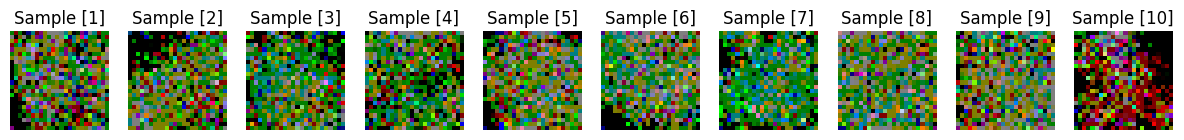

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [290/1000], Loss: 0.06447


999it [01:30, 11.05it/s]


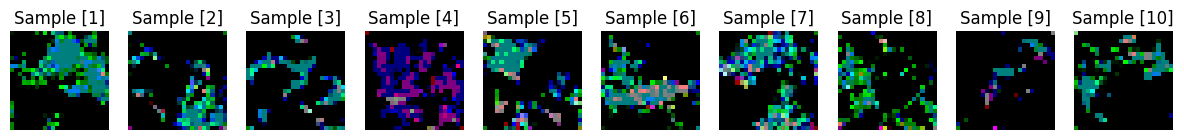

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [300/1000], Loss: 0.05175


999it [01:33, 10.69it/s]


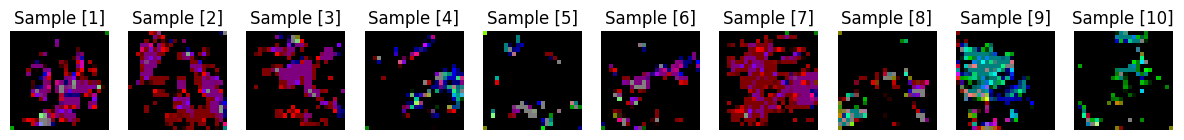

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [310/1000], Loss: 0.05454


999it [01:37, 10.26it/s]


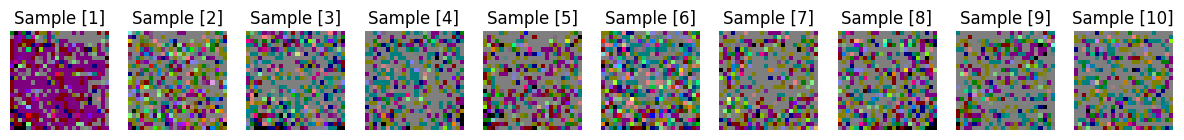

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch [320/1000], Loss: 0.05905


999it [01:36, 10.37it/s]


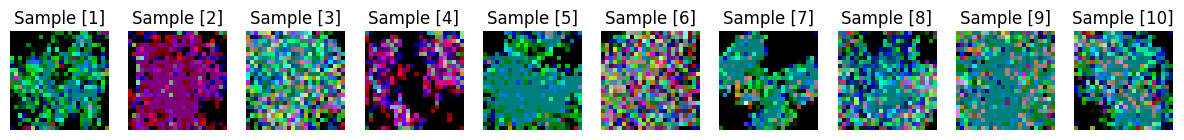

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch [330/1000], Loss: 0.04656


999it [01:35, 10.49it/s]


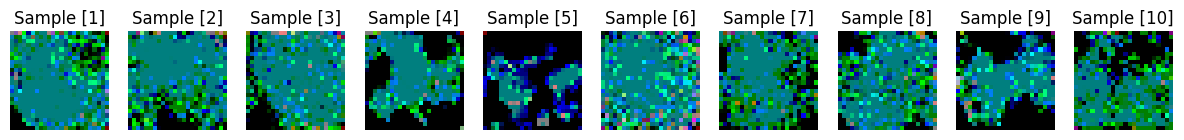

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch [340/1000], Loss: 0.05086


999it [01:35, 10.45it/s]


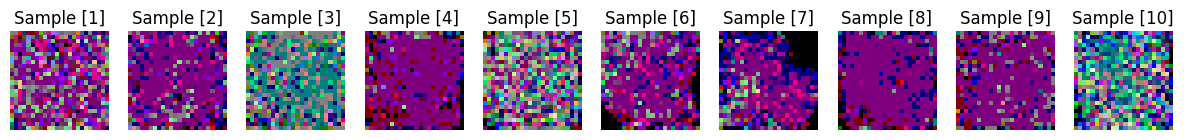

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [350/1000], Loss: 0.05589


999it [01:34, 10.56it/s]


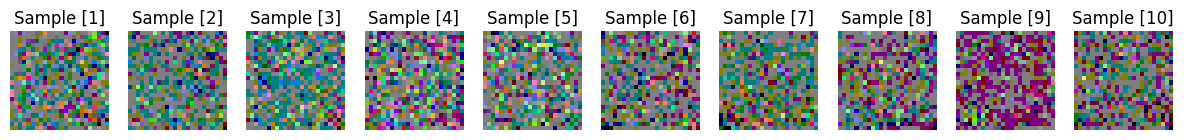

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [360/1000], Loss: 0.05162


999it [01:35, 10.46it/s]


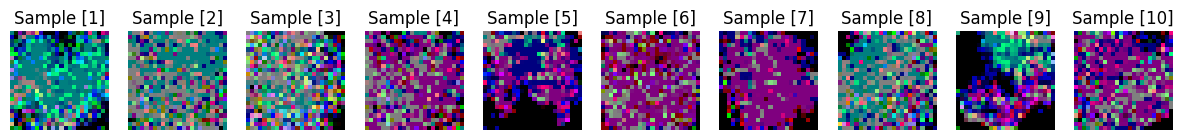

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [370/1000], Loss: 0.06172


999it [01:30, 11.08it/s]


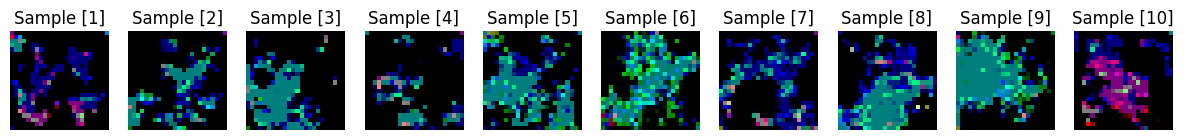

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [380/1000], Loss: 0.04238


999it [01:30, 11.10it/s]


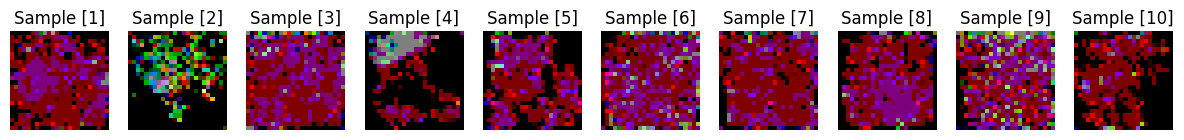

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [390/1000], Loss: 0.04964


999it [01:31, 10.92it/s]


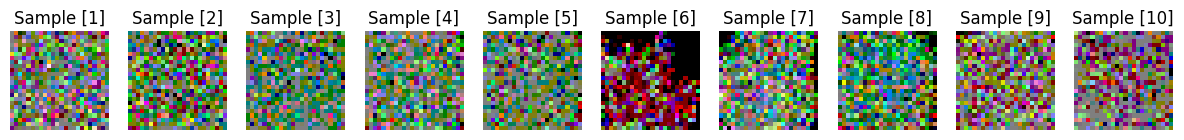

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [400/1000], Loss: 0.04603


999it [01:31, 10.87it/s]


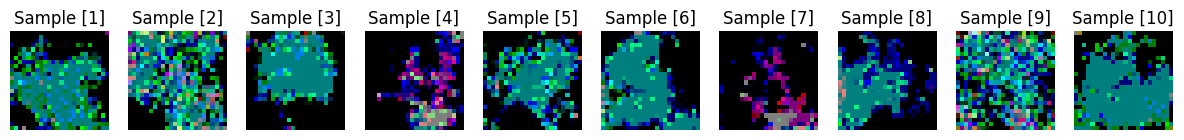

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [410/1000], Loss: 0.04649


999it [01:32, 10.78it/s]


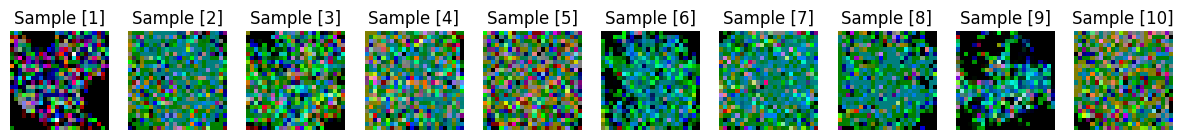

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [420/1000], Loss: 0.05805


999it [01:28, 11.29it/s]


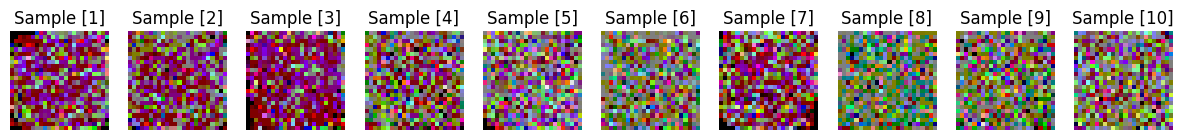

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Epoch [430/1000], Loss: 0.05096


999it [01:29, 11.12it/s]


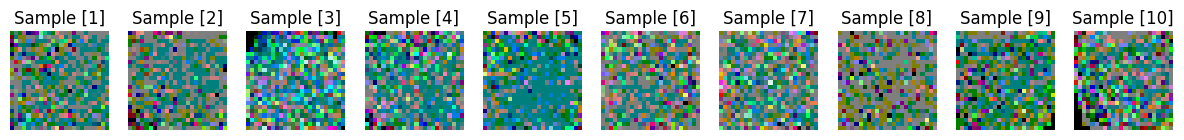

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch [440/1000], Loss: 0.04593


999it [01:29, 11.17it/s]


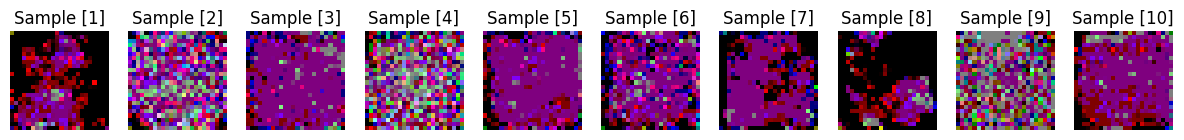

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [450/1000], Loss: 0.03781


999it [01:29, 11.14it/s]


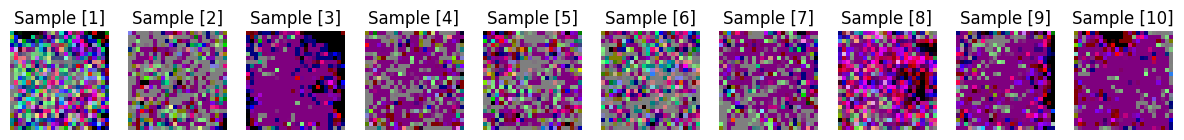

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [460/1000], Loss: 0.05790


999it [01:29, 11.15it/s]


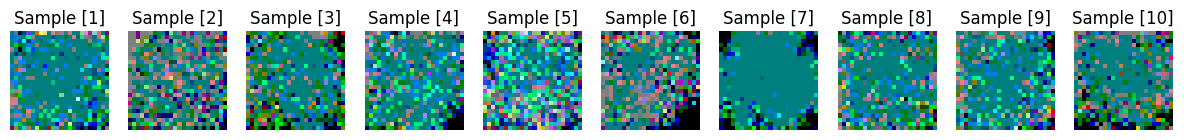

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [470/1000], Loss: 0.05486


999it [01:29, 11.17it/s]


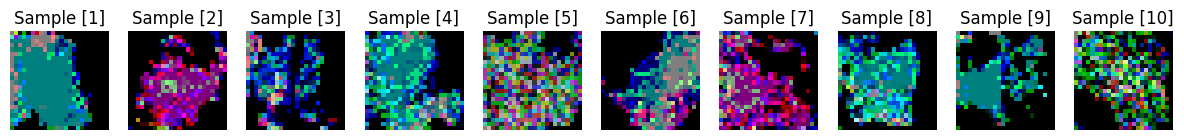

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [480/1000], Loss: 0.07039


999it [01:30, 11.01it/s]


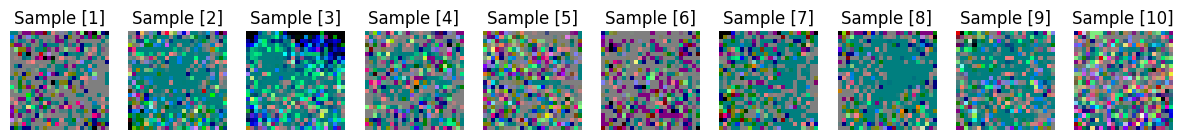

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [490/1000], Loss: 0.04796


999it [01:30, 11.03it/s]


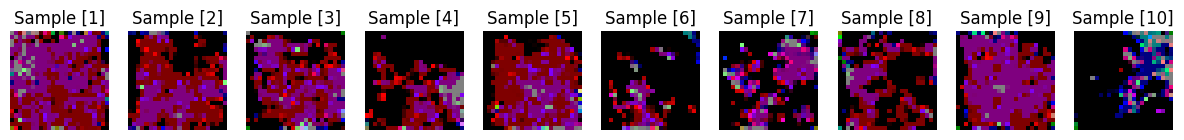

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Epoch [500/1000], Loss: 0.04892


999it [01:29, 11.15it/s]


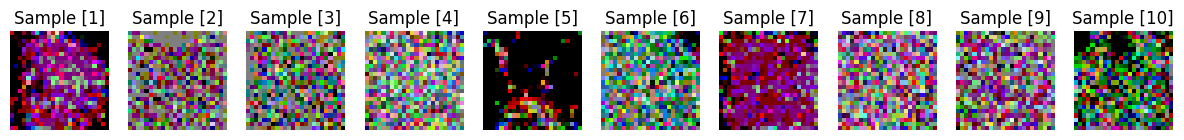

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch [510/1000], Loss: 0.05694


999it [01:29, 11.16it/s]


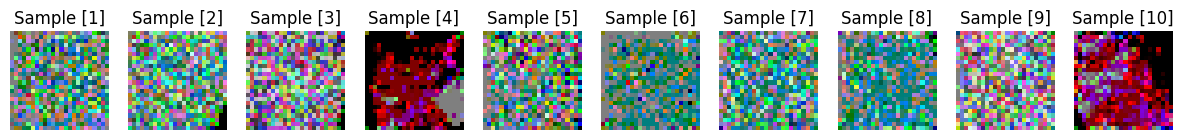

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [520/1000], Loss: 0.05852


999it [01:29, 11.21it/s]


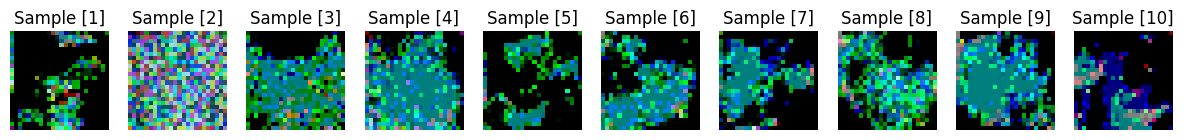

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch [530/1000], Loss: 0.02943


999it [01:29, 11.17it/s]


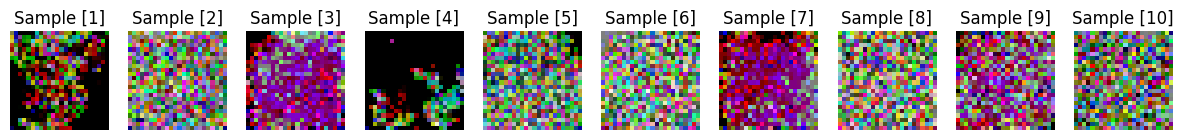

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [540/1000], Loss: 0.04447


999it [01:30, 11.08it/s]


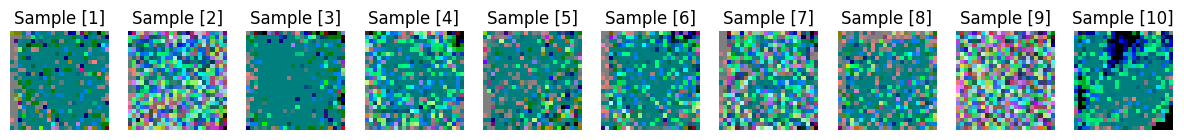

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [550/1000], Loss: 0.05163


999it [01:29, 11.20it/s]


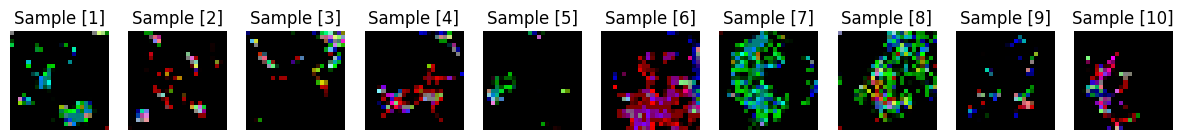

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [560/1000], Loss: 0.04035


999it [01:28, 11.24it/s]


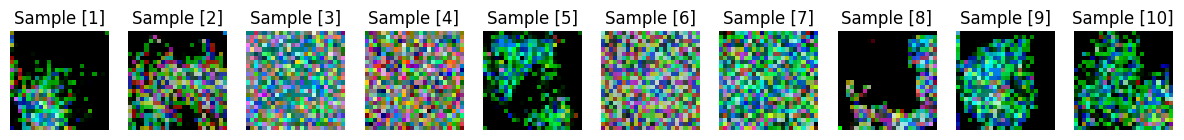

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Epoch [570/1000], Loss: 0.03337


999it [01:29, 11.20it/s]


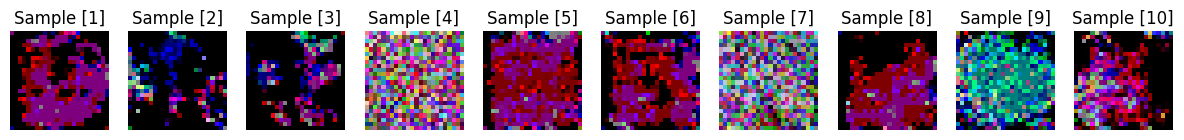

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch [580/1000], Loss: 0.03844


999it [01:29, 11.18it/s]


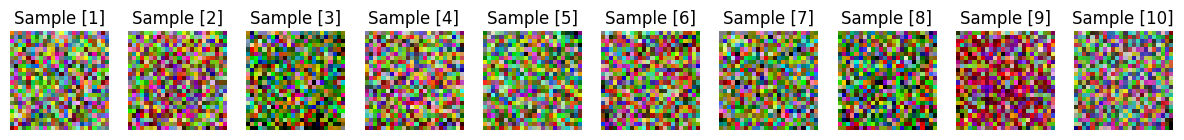

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch [590/1000], Loss: 0.04615


999it [01:29, 11.19it/s]


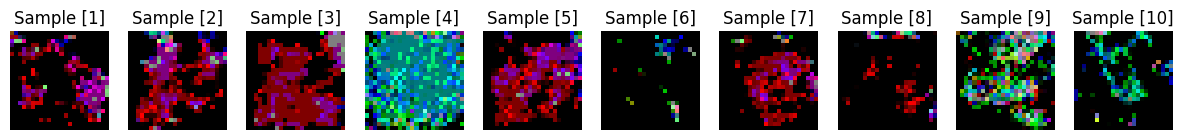

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [600/1000], Loss: 0.04206


999it [01:29, 11.15it/s]


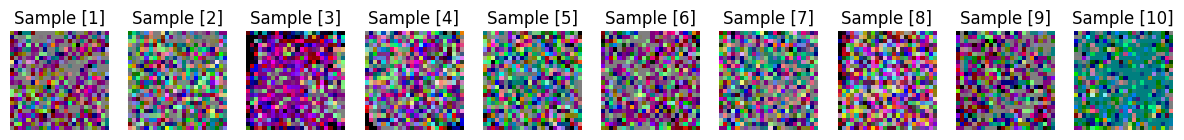

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [610/1000], Loss: 0.04145


999it [01:29, 11.19it/s]


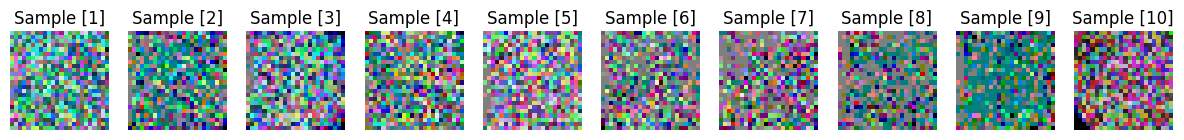

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch [620/1000], Loss: 0.04359


999it [01:29, 11.14it/s]


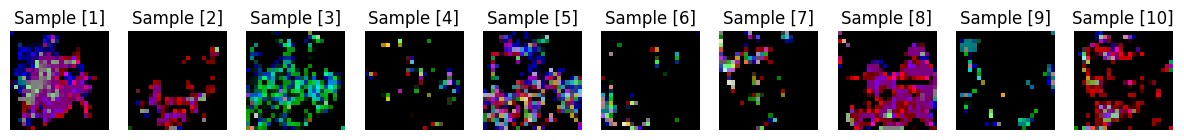

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch [630/1000], Loss: 0.04236


999it [01:28, 11.25it/s]


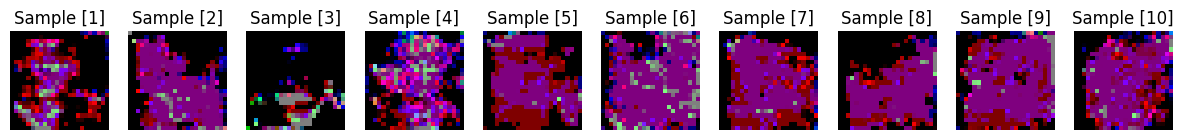

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Epoch [640/1000], Loss: 0.05143


999it [01:28, 11.26it/s]


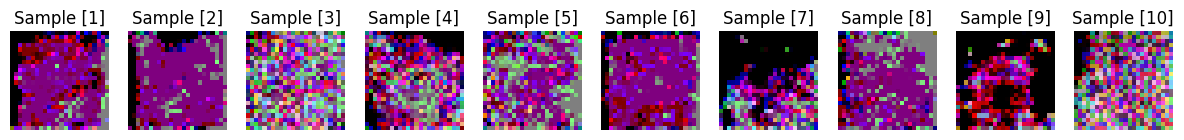

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [650/1000], Loss: 0.04123


999it [01:30, 10.98it/s]


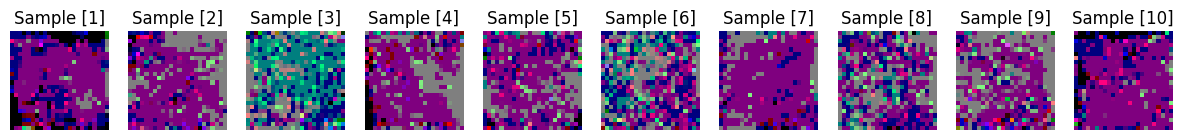

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [660/1000], Loss: 0.03943


999it [01:29, 11.16it/s]


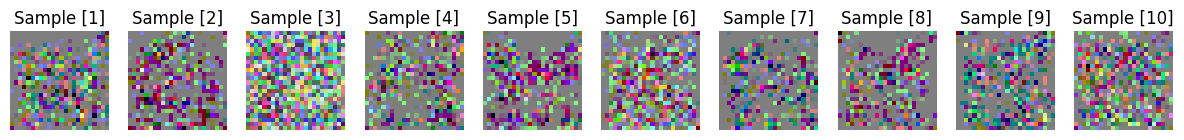

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch [670/1000], Loss: 0.03221


999it [01:29, 11.17it/s]


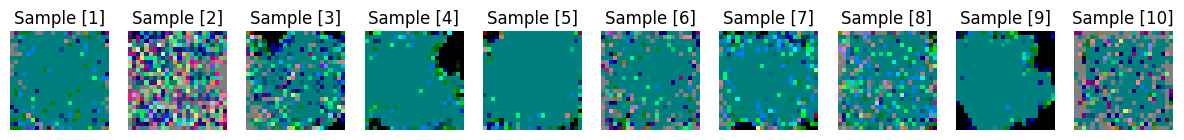

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [680/1000], Loss: 0.03623


999it [01:28, 11.23it/s]


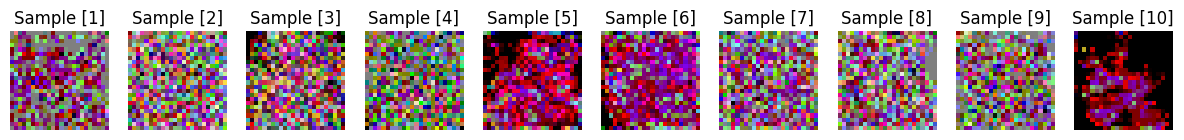

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [690/1000], Loss: 0.03725


999it [01:28, 11.24it/s]


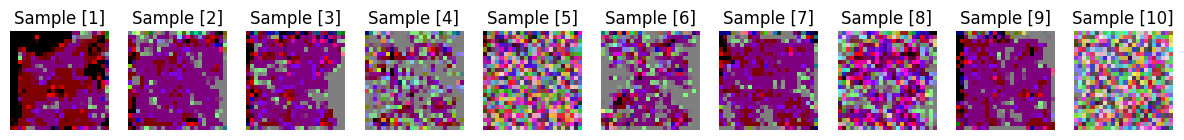

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [700/1000], Loss: 0.03739


999it [01:29, 11.17it/s]


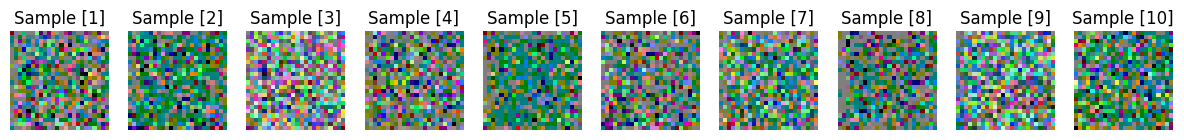

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Epoch [710/1000], Loss: 0.05188


999it [01:29, 11.15it/s]


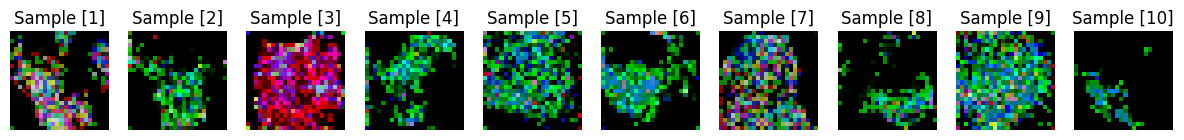

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [720/1000], Loss: 0.04384


999it [01:28, 11.24it/s]


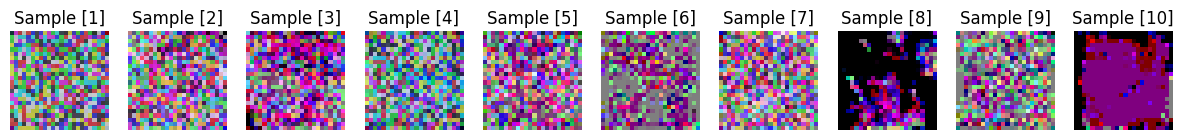

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Epoch [730/1000], Loss: 0.04912


999it [01:28, 11.25it/s]


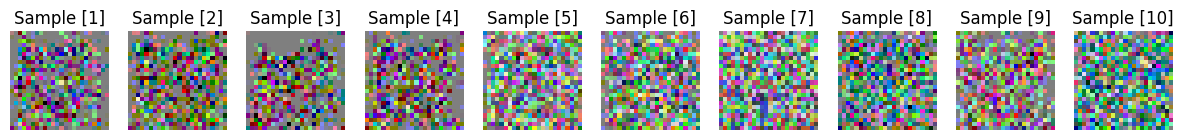

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch [740/1000], Loss: 0.04239


999it [01:28, 11.23it/s]


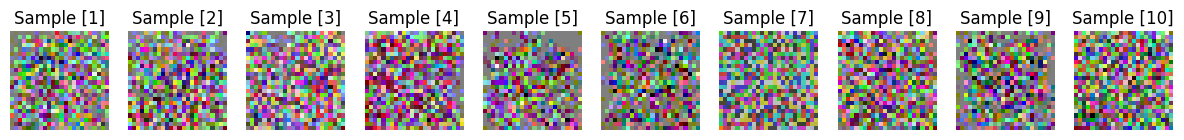

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch [750/1000], Loss: 0.03017


999it [01:28, 11.24it/s]


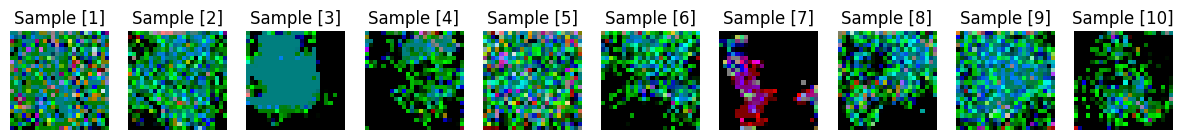

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [760/1000], Loss: 0.04342


999it [01:29, 11.15it/s]


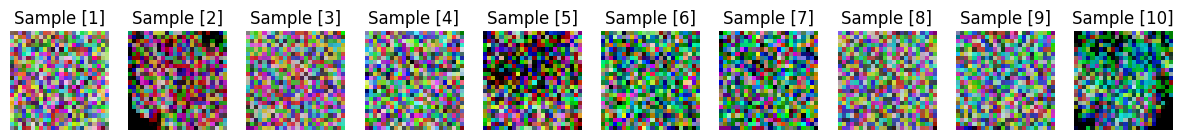

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [770/1000], Loss: 0.04585


999it [01:30, 11.09it/s]


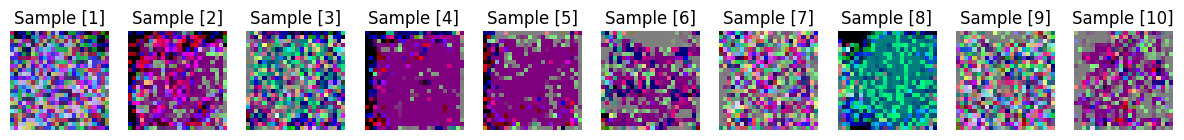

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [780/1000], Loss: 0.04250


999it [01:29, 11.14it/s]


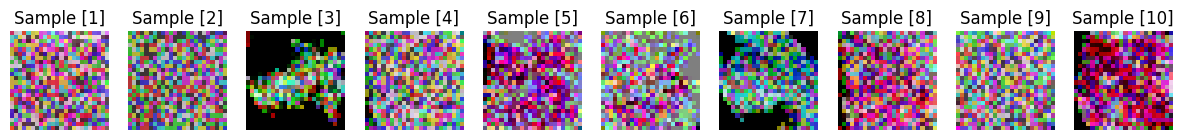

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [790/1000], Loss: 0.03400


999it [01:29, 11.13it/s]


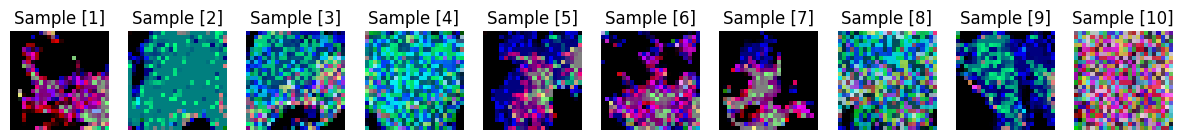

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Epoch [800/1000], Loss: 0.04237


999it [01:29, 11.17it/s]


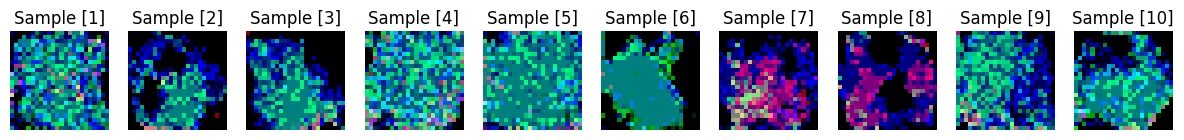

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [810/1000], Loss: 0.03642


999it [01:29, 11.16it/s]


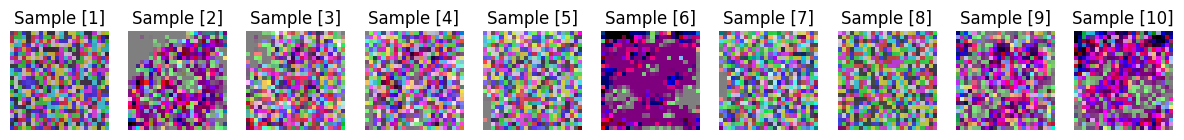

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch [820/1000], Loss: 0.03651


999it [01:29, 11.21it/s]


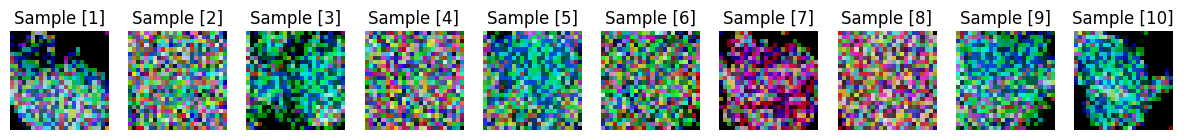

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch [830/1000], Loss: 0.03102


999it [01:29, 11.22it/s]


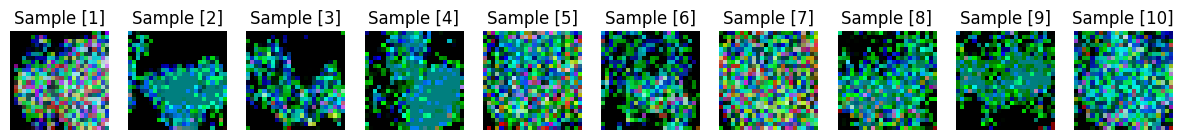

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch [840/1000], Loss: 0.03964


999it [01:29, 11.15it/s]


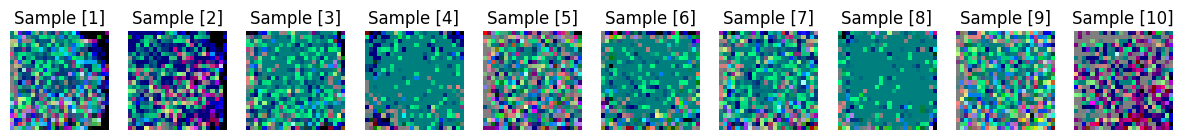

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [850/1000], Loss: 0.05014


999it [01:29, 11.13it/s]


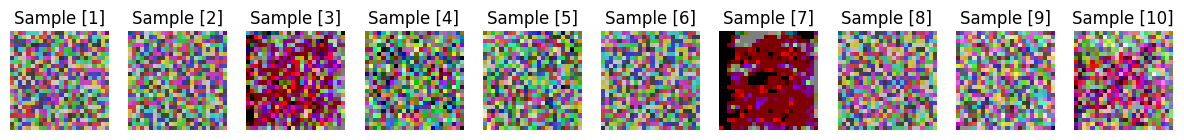

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [860/1000], Loss: 0.02835


999it [01:29, 11.12it/s]


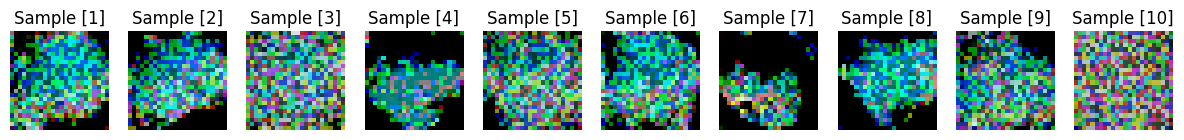

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch [870/1000], Loss: 0.03726


999it [01:29, 11.13it/s]


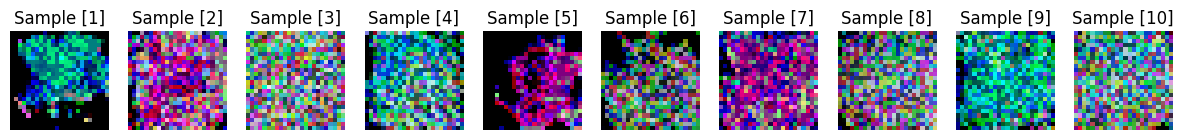

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch [880/1000], Loss: 0.03502


999it [01:29, 11.11it/s]


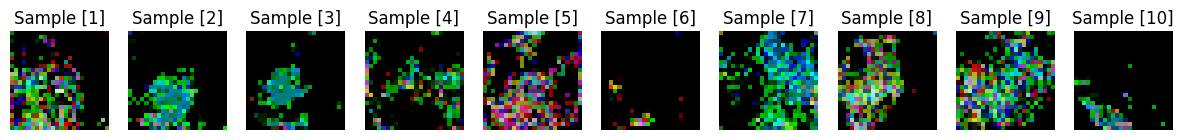

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch [890/1000], Loss: 0.04502


999it [01:29, 11.17it/s]


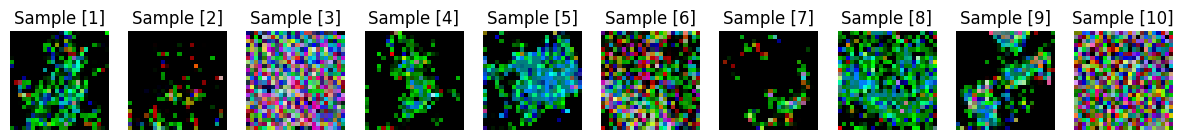

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Epoch [900/1000], Loss: 0.04135


999it [01:29, 11.15it/s]


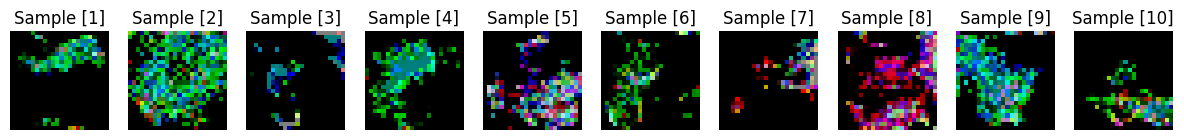

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [910/1000], Loss: 0.04761


999it [01:29, 11.22it/s]


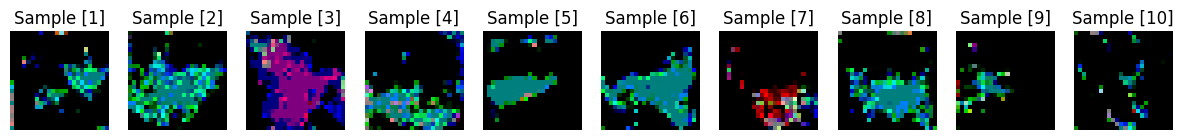

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch [920/1000], Loss: 0.03918


999it [01:29, 11.17it/s]


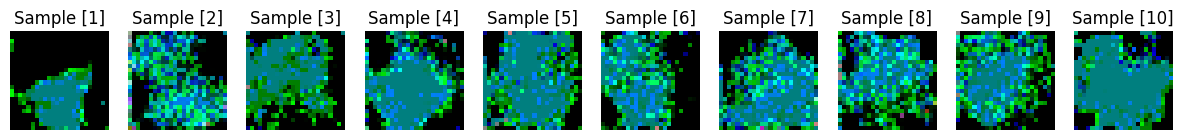

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch [930/1000], Loss: 0.03592


999it [01:29, 11.15it/s]


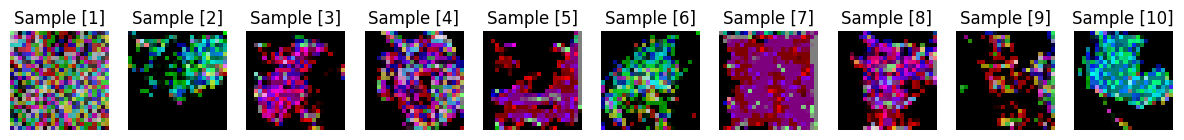

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch [940/1000], Loss: 0.03197


999it [01:30, 11.08it/s]


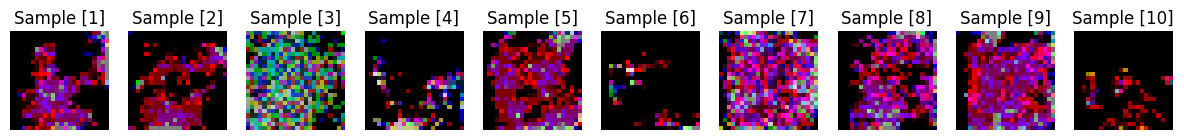

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [950/1000], Loss: 0.03404


999it [01:29, 11.12it/s]


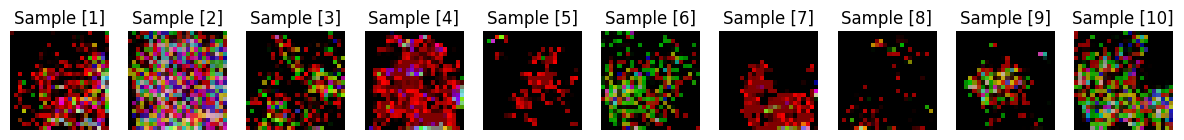

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [960/1000], Loss: 0.03749


999it [01:29, 11.14it/s]


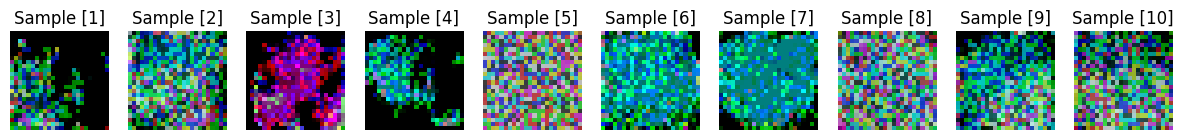

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch [970/1000], Loss: 0.03944


999it [01:29, 11.18it/s]


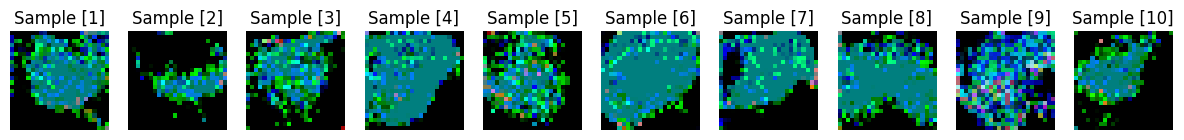

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Epoch [980/1000], Loss: 0.03628


999it [01:30, 11.01it/s]


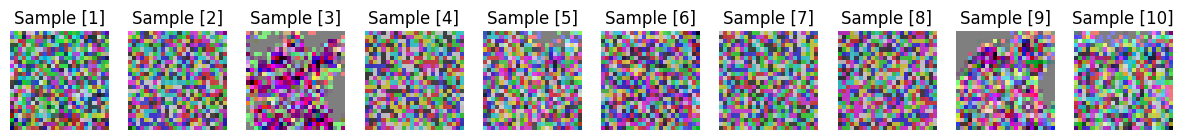

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [990/1000], Loss: 0.03394


999it [01:30, 11.08it/s]


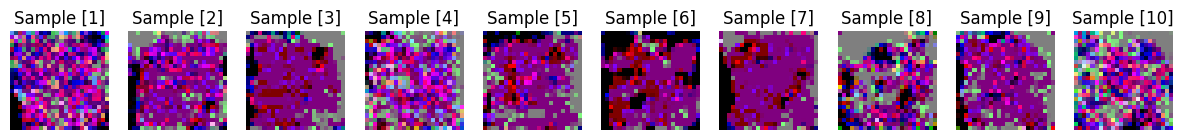

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch [1000/1000], Loss: 0.04073


999it [01:28, 11.29it/s]


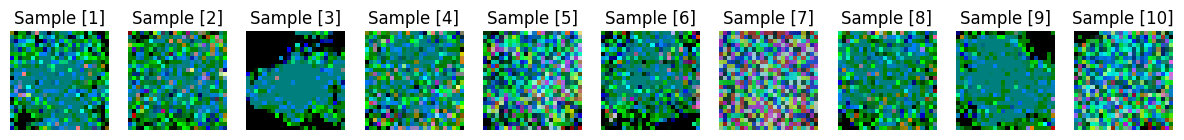

In [99]:
T = 1000
beta_0=1e-3
beta_T=0.02

lr = 3e-4
num_epochs = 1000


def train():
    device = 'cpu'
    dataloader = data_iter
    model = SmallUNet(device=device,image_size=image_size).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fct = nn.MSELoss()
    diffusion = Diffusion(data_shape=(image_size,image_size), device=device, T=T,beta_0=beta_0,beta_T=beta_T)

    for epoch in range(num_epochs+1):
        # fill code here
        total_loss = 0.0

        pbar = tqdm(dataloader)
        for i, (x_0, _) in enumerate(pbar):
            x_0 = x_0.to(device)
            t = diffusion.sample_timesteps(x_0.size(0)).to(device)
            x_t, noice = diffusion.forward_diffusion(x_0, t)
            predicted_noice = model(x_t, t)
            loss = loss_fct(noice, predicted_noice)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        if epoch != 0 and epoch % 10 == 0:
            #sample eine gewisse Anzahl (z.B. 10) an Bildern und plotten Sie diese um den Trainingsverlauf zu zu beobatchten
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {total_loss / len(dataloader):.5f}")
            
            images = []
            images_to_sample = 10
            sampled_images = diffusion.reverse_diffusion(model, images_to_sample)
            
            for image in sampled_images:
                images.append(reverse_transform(image))

            fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
            for i, ax in enumerate(axes):
                ax.imshow(images[i])
                ax.set_title(f"Sample {[i+1]}")
                ax.axis("off")
            plt.show()

    return model,diffusion
        
model,diffusion = train()